In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from collections import ChainMap

import json

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

%matplotlib inline
%config InlineBackend.figure_format='retina'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce RTX 2070 SUPER'

In [2]:
og_df = pd.read_csv("gvdb-aggregated-db\Articles-with-extracted-info.tsv", sep='\t')
og_df.head()

,Article_url,Article_title,Full_text,Json,Publication_date
0,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00
1,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00
2,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00
3,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00
4,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00


In [3]:
print(og_df.iloc[0] == og_df.iloc[0])

Article_url         True
Article_title       True
Full_text           True
Json                True
Publication_date    True
Name: 0, dtype: bool


In [4]:
#df = og_df.drop_duplicates()

In [5]:
df = og_df
df

,Article_url,Article_title,Full_text,Json,Publication_date
0,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00
1,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00
2,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00
3,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00
4,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00
...,...,...,...,...,...
23898,http://www.nbcphiladelphia.com/news/local/Woma...,Woman Dies After Being Shot in Head Along Nice...,A woman has been killed after being shot in th...,"{""circumstances"":{""number-of-shots-fired"":{""en...",2017-11-09 00:00:00+00:00
23899,gold-data15.com,Bridgeport man murdered in 9th homocide this year,"Bridgeport, Connecticut -- Christopher Pettway...","{""circumstances"":{""number-of-shots-fired"":{""en...",2014-07-29 00:00:00+00:00
23900,gold-data16.com,23 year old man shot dead in nightclub,"OAKLAND, CA -- A 23-year-old Hispanic man was ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2014-10-21 00:00:00+00:00
23901,http://gold-data17.com/,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00


In [6]:
df.shape

(23903, 5)

In [7]:
df = df.join(df['Json'].apply(json.loads).apply(pd.Series))

In [8]:
df.columns = df.columns.str.strip().str.lower().str.replace('-', '_')

In [9]:
df

,article_url,article_title,full_text,json,publication_date,circumstances,date_and_time,radio1,radio2,radio3,shooter_section,victim_section
0,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v..."
1,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v..."
2,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Yes', 'Drugs (other...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 65, 'startIndex': 54, 'v...","[{'age': {'endIndex': 65, 'startIndex': 54, 'v..."
3,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 122, 's...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 56, 'startIndex': 54, 'v...","[{'age': {'endIndex': 56, 'startIndex': 54, 'v..."
4,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 13, 'startIndex': 12, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': -1, 'startIndex': -1, 'v..."
...,...,...,...,...,...,...,...,...,...,...,...,...
23898,http://www.nbcphiladelphia.com/news/local/Woma...,Woman Dies After Being Shot in Head Along Nice...,A woman has been killed after being shot in th...,"{""circumstances"":{""number-of-shots-fired"":{""en...",2017-11-09 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 153, 'startIndex': 140, ...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,[],"[{'age': {'endIndex': 182, 'startIndex': 179, ..."
23899,gold-data15.com,Bridgeport man murdered in 9th homocide this year,"Bridgeport, Connecticut -- Christopher Pettway...","{""circumstances"":{""number-of-shots-fired"":{""en...",2014-07-29 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 1073, '...","{'city': {'endIndex': 59, 'startIndex': 49, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,[],"[{'age': {'endIn

In [10]:
df_s = pd.DataFrame(df.shooter_section)

In [11]:

df.shooter_section[2][0].get('race').get('value')
# sns.countplot(x='race', data = df.victim_section[0][0].get('race').get('value'))

'white'

In [12]:
from collections import ChainMap
multiDct_to_single=[]
for i in range(len(df['shooter_section'])):
    qq=dict(ChainMap(*df['shooter_section'][i][::-1]))
    multiDct_to_single.append(qq)
df_flat= pd.DataFrame(multiDct_to_single)
df_flat

,age,gender,name,race
0,"{'endIndex': 22, 'startIndex': 20, 'value': '26'}",Male,"{'endIndex': 45, 'startIndex': 63, 'value': 'J...","{'endIndex': -1, 'startIndex': -1, 'value': ''}"
1,"{'endIndex': 22, 'startIndex': 20, 'value': '26'}",Male,"{'endIndex': 45, 'startIndex': 63, 'value': 'J...","{'endIndex': -1, 'startIndex': -1, 'value': ''}"
2,"{'endIndex': 65, 'startIndex': 54, 'value': '2...",Male,"{'endIndex': -1, 'startIndex': -1, 'value': ''}","{'endIndex': 71, 'startIndex': 66, 'value': 'w..."
3,"{'endIndex': 56, 'startIndex': 54, 'value': '23'}",Male,"{'endIndex': -1, 'startIndex': -1, 'value': ''}","{'endIndex': 71, 'startIndex': 66, 'value': 'w..."
4,"{'endIndex': 22, 'startIndex': 20, 'value': '26'}",Male,"{'endIndex': 45, 'startIndex': 32, 'value': 'J...","{'endIndex': -1, 'startIndex': -1, 'value': ''}"
...,...,...,...,...
23898,NaN,NaN,NaN,NaN
23899,NaN,NaN,NaN,NaN
23900,NaN,NaN,NaN,NaN
23901,"{'endIndex': 100, 'startIndex': 98, 'value': '...",Male,"{'endIndex': -1, 'startIndex': -1, 'value': ''}","{'endIndex': 115, 'startIndex': 110, 'value': ..."


In [13]:
def func(dict_):
    h=defaultdict(list)
    for j in dict_:
        if type(j)!=str:
            for i in j.items():
                h[i[0]].append(i[1])
    return h


t_=[]
g=defaultdict(list)
for i in range(len(df_flat['race'])):
    tdict = df_flat['race'][i]
    if not isinstance(tdict,float):
        t_.append(tdict.get('value').strip().lower())
    else:
        t_.append("NaN")
df_race = pd.DataFrame(t_)
df_race.columns = ["race"]
df_race

,race
0,
1,
2,white
3,white
4,
...,...
23898,NaN
23899,NaN
23900,NaN
23901,white


In [14]:
# sLength = len(df['article_title'])
#df = df.assign(df_race=pd.Series(np.random.randn(sLength)).values)
#df = df.join(df_race.apply(pd.Series))
df['race'] = df_race.values
df

,article_url,article_title,full_text,json,publication_date,circumstances,date_and_time,radio1,radio2,radio3,shooter_section,victim_section,race
0,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",
1,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",
2,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Yes', 'Drugs (other...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 65, 'startIndex': 54, 'v...","[{'age': {'endIndex': 65, 'startIndex': 54, 'v...",white
3,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 122, 's...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 56, 'startIndex': 54, 'v...","[{'age': {'endIndex': 56, 'startIndex': 54, 'v...",white
4,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 13, 'startIndex': 12, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': -1, 'startIndex': -1, 'v...",
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,http://www.nbcphiladelphia.com/news/local/Woma...,Woman Dies After Being Shot in Head Along Nice...,A woman has been killed after being shot in th...,"{""circumstances"":{""number-of-shots-fired"":{""en...",2017-11-09 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 153, 'startIndex': 140, ...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,[],"[{'age': {'endIndex': 182, 'startIndex': 179, ...",NaN
23899,gold-data15.com,Bridgeport man murdered in 9th homocide this year,"Bridgeport, Connecticut -- Christopher Pettway...","{""circumstances"":{""number-of-shots-fired"":{""en...",2014-07-29 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 1073, '...","{'city': {'endIndex': 59, 'startIndex': 49, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/vict

In [15]:
#    if type(df_flat['race'][i])!=str:
#        t_.append(func(df_flat['race'][i]))
#    
#    else:
#        tups=tuple(zip(df_flat['race'][0][0].keys() ,
#                               ['Nope']*len(df_flat['race'][0][0].keys())))
#        for n in tups:
#            g[n[0]].append(n[1])
#        t_.append(g)

#print(pd.DataFrame(t_).url[0])
#print('--------------------')
#print(pd.DataFrame(t_).url[1])

#url_expand_=pd.DataFrame(t_)
#url_expand_

In [16]:
# shooters_list = list(df['shooter_section'].items())

In [17]:
# print(type(shooters_list))
# thislist = shooters_list[99][1]
# print(thislist)
# thislist[0]['race'].get('value')

In [18]:
# races = []
# for case in shooters_list:
    ## info_list = shooters_list[case][1]
    ## races.append(info_list[0]['race'].get('value'))
    ## print(case[1])
    # temp = case[1]
    # print(temp[0]['race'].get('value'))

In [19]:
df

,article_url,article_title,full_text,json,publication_date,circumstances,date_and_time,radio1,radio2,radio3,shooter_section,victim_section,race
0,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",
1,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",
2,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Yes', 'Drugs (other...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 65, 'startIndex': 54, 'v...","[{'age': {'endIndex': 65, 'startIndex': 54, 'v...",white
3,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 122, 's...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 56, 'startIndex': 54, 'v...","[{'age': {'endIndex': 56, 'startIndex': 54, 'v...",white
4,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 13, 'startIndex': 12, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': -1, 'startIndex': -1, 'v...",
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,http://www.nbcphiladelphia.com/news/local/Woma...,Woman Dies After Being Shot in Head Along Nice...,A woman has been killed after being shot in th...,"{""circumstances"":{""number-of-shots-fired"":{""en...",2017-11-09 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 153, 'startIndex': 140, ...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,[],"[{'age': {'endIndex': 182, 'startIndex': 179, ...",NaN
23899,gold-data15.com,Bridgeport man murdered in 9th homocide this year,"Bridgeport, Connecticut -- Christopher Pettway...","{""circumstances"":{""number-of-shots-fired"":{""en...",2014-07-29 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 1073, '...","{'city': {'endIndex': 59, 'startIndex': 49, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/vict

In [20]:
import nltk

In [21]:
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\khanda\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\khanda\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gazetteers is already up-to-date!
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\khanda\AppData\Roaming\nltk_data...
[nltk_data]    |   Package genesis is already up-to-date!
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\khanda\AppData\Roaming\nltk_data...
[nltk_data]    |   Package gutenberg is already up-to-date!
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\khanda\AppData\Roaming\nltk_data...
[nltk_data]    |   Package inaugural is already up-to-date!
[nltk_data]    | Downloading package movie_reviews to
[nltk_dat

True

In [22]:
df['tokenized_title'] = df["article_title"].apply(word_tokenize)

In [23]:
df

,article_url,article_title,full_text,json,publication_date,circumstances,date_and_time,radio1,radio2,radio3,shooter_section,victim_section,race,tokenized_title
0,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",,"[Man, shoots, self, accidentally, while, in, car]"
1,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",,"[Man, shoots, self, accidentally, while, in, car]"
2,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Yes', 'Drugs (other...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 65, 'startIndex': 54, 'v...","[{'age': {'endIndex': 65, 'startIndex': 54, 'v...",white,"[Man, accidentally, shoots, himself, cleaning,..."
3,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 122, 's...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 56, 'startIndex': 54, 'v...","[{'age': {'endIndex': 56, 'startIndex': 54, 'v...",white,"[Man, accidentally, shoots, himself, cleaning,..."
4,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 13, 'startIndex': 12, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': -1, 'startIndex': -1, 'v...",,"[Man, shoots, self, accidentally, while, in, car]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,http://www.nbcphiladelphia.com/news/local/Woma...,Woman Dies After Being Shot in Head Along Nice...,A woman has been killed after being shot in th...,"{""circumstances"":{""number-of-shots-fired"":{""en...",2017-11-09 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 153, 'startIndex': 140, ...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,[],"[{'age': {'endIndex': 182, 'startIndex': 179, ...",NaN,"[Woman, Dies, After, Being, Shot, in, Head, Al..."
23899,gold-data15.com,Bridgeport man murdered in 9th homocide this year,"Bridgeport, Connecticut -- Christopher Pettway..."

In [24]:
df

,article_url,article_title,full_text,json,publication_date,circumstances,date_and_time,radio1,radio2,radio3,shooter_section,victim_section,race,tokenized_title
0,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",,"[Man, shoots, self, accidentally, while, in, car]"
1,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",,"[Man, shoots, self, accidentally, while, in, car]"
2,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Yes', 'Drugs (other...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 65, 'startIndex': 54, 'v...","[{'age': {'endIndex': 65, 'startIndex': 54, 'v...",white,"[Man, accidentally, shoots, himself, cleaning,..."
3,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 122, 's...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 56, 'startIndex': 54, 'v...","[{'age': {'endIndex': 56, 'startIndex': 54, 'v...",white,"[Man, accidentally, shoots, himself, cleaning,..."
4,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 13, 'startIndex': 12, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': -1, 'startIndex': -1, 'v...",,"[Man, shoots, self, accidentally, while, in, car]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,http://www.nbcphiladelphia.com/news/local/Woma...,Woman Dies After Being Shot in Head Along Nice...,A woman has been killed after being shot in th...,"{""circumstances"":{""number-of-shots-fired"":{""en...",2017-11-09 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 153, 'startIndex': 140, ...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,[],"[{'age': {'endIndex': 182, 'startIndex': 179, ...",NaN,"[Woman, Dies, After, Being, Shot, in, Head, Al..."
23899,gold-data15.com,Bridgeport man murdered in 9th homocide this year,"Bridgeport, Connecticut -- Christopher Pettway..."

In [25]:
v = TfidfVectorizer()
x = v.fit_transform(df['article_title'])

In [26]:
df['title_vect'] = list(x)

In [27]:
df

,article_url,article_title,full_text,json,publication_date,circumstances,date_and_time,radio1,radio2,radio3,shooter_section,victim_section,race,tokenized_title,title_vect
0,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",,"[Man, shoots, self, accidentally, while, in, car]","(0, 1721)\t0.4563040367696755\n (0, 4737)\t..."
1,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 451, 's...","{'city': {'endIndex': 8, 'startIndex': 0, 'val...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'No', 'Drugs (other ...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': 22, 'startIndex': 32, 'v...",,"[Man, shoots, self, accidentally, while, in, car]","(0, 1721)\t0.4563040367696755\n (0, 4737)\t..."
2,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Yes', 'Drugs (other...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 65, 'startIndex': 54, 'v...","[{'age': {'endIndex': 65, 'startIndex': 54, 'v...",white,"[Man, accidentally, shoots, himself, cleaning,...","(0, 4232)\t0.3975455962537428\n (0, 2105)\t..."
3,gold-data2.com,Man accidentally shoots himself cleaning gun,"BLOOMINGTON, IL - On Thursday evening, Septemb...","{""circumstances"":{""number-of-shots-fired"":{""en...",2013-09-06 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': 122, 's...","{'city': {'endIndex': 11, 'startIndex': 0, 'va...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 56, 'startIndex': 54, 'v...","[{'age': {'endIndex': 56, 'startIndex': 54, 'v...",white,"[Man, accidentally, shoots, himself, cleaning,...","(0, 4232)\t0.3975455962537428\n (0, 2105)\t..."
4,gold-data1.com,Man shoots self accidentally while in car,"Atlantic City, Wyo. 26-year-old Joe Henderson ...","{""circumstances"":{""number-of-shots-fired"":{""en...",2015-01-03 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 13, 'startIndex': 12, 'v...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned by the victim/victims ...,"[{'age': {'endIndex': 22, 'startIndex': 20, 'v...","[{'age': {'endIndex': -1, 'startIndex': -1, 'v...",,"[Man, shoots, self, accidentally, while, in, car]","(0, 1721)\t0.4563040367696755\n (0, 4737)\t..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23898,http://www.nbcphiladelphia.com/news/local/Woma...,Woman Dies After Being Shot in Head Along Nice...,A woman has been killed after being shot in th...,"{""circumstances"":{""number-of-shots-fired"":{""en...",2017-11-09 00:00:00+00:00,"{'number-of-shots-fired': {'endIndex': -1, 'st...","{'city': {'endIndex': 153, 'startIndex': 140, ...",{'The firearm was used during another crime.':...,"{'Alcohol was involved.': 'Not mentioned', 'Dr...",{'The firearm was owned 

In [28]:
print(df['title_vect'][0])

  (0, 1721)	0.4563040367696755
  (0, 4737)	0.13795119470958206
  (0, 9904)	0.452601971846722
  (0, 306)	0.4100683058394725
  (0, 8294)	0.44386713360405866
  (0, 8435)	0.3976772299113978
  (0, 5922)	0.21115473484725697


In [29]:
(df.race == 'african-american').sum()

10

In [30]:
((df.race != 'white') & (df.race !='') & (df.race !='NaN')).sum()

925

In [31]:
((df.race == 'hispanic') | (df.race == 'asian') | (df.race == 'mexican') | (df.race == 'black') | (df.race == 'African American') | (df.race == 'Asian-American') | (df.race == 'Afrian-American') | (df.race == 'Asian-American') ).sum()

491

In [32]:
df['race'] = df.race.str.lower()
aa_arr = []
asian_arr = []
hisp_arr = [] 
white_arr = []
empty_arr = []

In [33]:
aa_arr = (df.index[df.race == 'black']) | (df.index[df.race == 'african']) | (df.index[df.race == 'african-american']) | (df.index[df.race == 'african american'])
asian_arr = (df.index[df.race == 'asian']) | (df.index[df.race == 'asian-american']) | (df.index[df.race == 'asian american']) | (df.index[df.race == 'chinese']) | (df.index[df.race == 'chinese-american']) | (df.index[df.race == 'chinese american']) | (df.index[df.race == 'vietnamese']) | (df.index[df.race == 'korean'])  
hisp_arr = (df.index[df.race == 'hispanic']) | (df.index[df.race == 'mexican'])
white_arr = (df.index[df.race == 'white']) | (df.index[df.race == 'caucasian'])
empty_arr = (df.index[df.race == 'nan']) | (df.index[df.race == ''])

<ipython-input-33-6661ce9a9c2f>:1: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  aa_arr = (df.index[df.race == 'black']) | (df.index[df.race == 'african']) | (df.index[df.race == 'african-american']) | (df.index[df.race == 'african american'])
<ipython-input-33-6661ce9a9c2f>:2: FutureWarning: Index.__or__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__or__.  Use index.union(other) instead
  asian_arr = (df.index[df.race == 'asian']) | (df.index[df.race == 'asian-american']) | (df.index[df.race == 'asian american']) | (df.index[df.race == 'chinese']) | (df.index[df.race == 'chinese-american']) | (df.index[df.race == 'chinese american']) | (df.index[df.race == 'vietnamese']) | (df.index[df.race == 'korean'])
<ipython-input-33-6661ce9a9c2f>:3: FutureWarning: Index.__or__ operating as a set operation

In [34]:
race_dict = {}
race_dict['aa'] = list(aa_arr)
race_dict['asian'] = list(asian_arr)
race_dict['hispanic'] = list(hisp_arr)
race_dict['white'] = list(white_arr)
race_dict

{'aa': [250,
  263,
  278,
  293,
  356,
  528,
  538,
  624,
  630,
  673,
  691,
  865,
  891,
  940,
  979,
  1034,
  1083,
  1281,
  1288,
  1443,
  1895,
  1898,
  1922,
  2196,
  2462,
  2972,
  3118,
  3599,
  3675,
  3696,
  3705,
  3771,
  3789,
  3839,
  3862,
  3876,
  4133,
  4154,
  4246,
  4397,
  4431,
  4523,
  4524,
  4528,
  4645,
  4653,
  4908,
  4992,
  5027,
  5033,
  5051,
  5056,
  5134,
  5436,
  5440,
  5452,
  5473,
  5700,
  5733,
  5742,
  5816,
  5874,
  5887,
  5898,
  5972,
  5974,
  5982,
  5989,
  6080,
  6112,
  6203,
  6212,
  6231,
  6380,
  6602,
  6655,
  6692,
  6729,
  6817,
  6825,
  6913,
  6923,
  6939,
  6941,
  6960,
  6963,
  6968,
  6969,
  6973,
  6974,
  6977,
  6979,
  7000,
  7054,
  7061,
  7062,
  7076,
  7079,
  7080,
  7081,
  7207,
  7209,
  7282,
  7300,
  7318,
  7331,
  7332,
  7345,
  7390,
  7403,
  7416,
  7433,
  7467,
  7473,
  7486,
  7529,
  7540,
  7544,
  7545,
  7552,
  7567,
  7573,
  7643,
  7655,
  7734,
  7759,
 

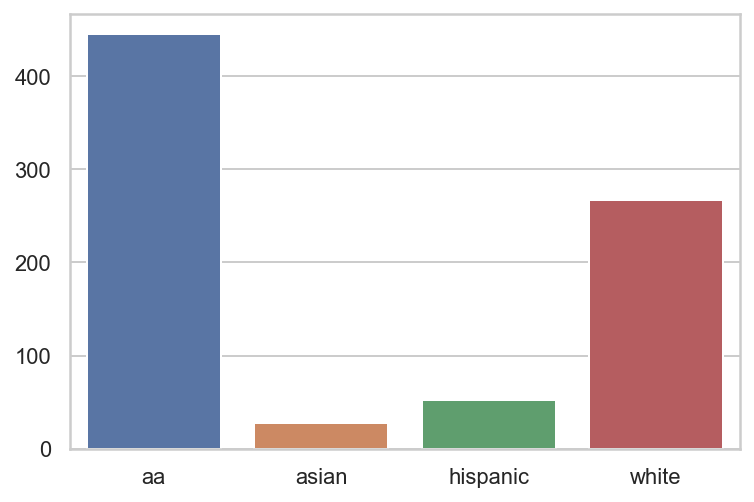

In [35]:
race_dict_lens = {}
race_dict_lens['aa'] = len(race_dict['aa'])
race_dict_lens['asian'] = len(race_dict['asian'])
race_dict_lens['hispanic'] = len(race_dict['hispanic'])
race_dict_lens['white'] = len(race_dict['white'])
df_r=pd.DataFrame.from_dict(race_dict_lens,orient='index').transpose()
sns.set_theme(style="whitegrid")
ax = sns.barplot(data=df_r)

In [36]:
white_token_dict = {};
for row in race_dict['white']:
    for word in (df['tokenized_title'][row]):
        if word in white_token_dict:
            white_token_dict[word.lower()] = white_token_dict[word.lower()] + 1
        else:
            white_token_dict[word.lower()] = 1
poc_token_dict = {};
for row in race_dict['aa']:
    for word in (df['tokenized_title'][row]):
        if word in poc_token_dict:
            poc_token_dict[word.lower()] = poc_token_dict[word.lower()] + 1
        else:
            poc_token_dict[word.lower()] = 1
for row in race_dict['asian']:
    for word in (df['tokenized_title'][row]):
        if word in poc_token_dict:
            poc_token_dict[word.lower()] = poc_token_dict[word.lower()] + 1
        else:
            poc_token_dict[word.lower()] = 1
for row in race_dict['hispanic']:
    for word in (df['tokenized_title'][row]):
        if word in poc_token_dict:
            poc_token_dict[word.lower()] = poc_token_dict[word.lower()] + 1
        else:
            poc_token_dict[word.lower()] = 1

In [37]:
poc_token_dict

{'police': 1,
 'say': 8,
 'shooting': 4,
 'near': 1,
 'city': 1,
 'market': 1,
 'injured': 2,
 '5': 4,
 ',': 375,
 'not': 2,
 '3': 4,
 '-': 426,
 'identify': 5,
 'suspect': 2,
 'in': 9,
 'memphis': 1,
 'officer': 1,
 "'s": 24,
 'killing': 1,
 'arrested': 10,
 'cop': 5,
 '12': 8,
 'news': 1,
 'ex-con': 1,
 'accused': 62,
 'of': 16,
 'turns': 60,
 'self': 60,
 'woman': 1,
 'finds': 1,
 'gunshot': 4,
 'victim': 7,
 'lex18.com': 1,
 '|': 193,
 'continuous': 1,
 'and': 8,
 'stormtracker': 1,
 'weather': 1,
 'two': 5,
 'by': 11,
 'gunfire': 3,
 'north': 1,
 'champaign': 1,
 'news-gazette.com': 1,
 'contracostatimes.com': 1,
 'manhunt': 1,
 'underway': 1,
 'for': 26,
 'fatal': 11,
 'journal': 1,
 'star': 1,
 'peoria': 1,
 'il': 1,
 'portland': 1,
 'seek': 10,
 'public': 3,
 'help': 1,
 'solving': 2,
 '2005': 2,
 'homicide': 1,
 'ktre.com': 1,
 'lufkin': 1,
 'nacogdoches': 1,
 'texas': 1,
 'nopd': 1,
 'releases': 4,
 'new': 1,
 'video': 3,
 'lower': 1,
 'garden': 1,
 'district': 1,
 'orleans':

In [38]:
word_frq = pd.DataFrame(columns = ['word', 'white_frq', 'poc_frq'])
for key, value in white_token_dict.items():
    #entry = {'word': [key], 'white_frq': [value], "poc_frq": ['NaN']}
    #new_entry_df = pd.DataFrame.from_dict(entry)
    #word_frq = word_frq.append(new_entry_df)
    word_frq.loc[len(word_frq.index)] = [key, value, 0] 


for key, value in poc_token_dict.items():
    if key in word_frq:
        print(word_frq['word'])
        word_frq.loc[word_frq.word == key, 'poc_frq'] = value
    else:
        word_frq.loc[len(word_frq.index)] = [key, 0, value] 

print(word_frq)

                 word white_frq poc_frq
0                 man         1       0
1        accidentally       134       0
2              shoots       137       0
3             himself       134       0
4            cleaning       133       0
...               ...       ...     ...
1911           sketch         0       1
1912          offered         0       1
1913      75-year-old         0       1
1914        9news.com         0       1
1915  channel3000.com         0       1

[1916 rows x 3 columns]


KeyError: 'Stock_Index_Price'

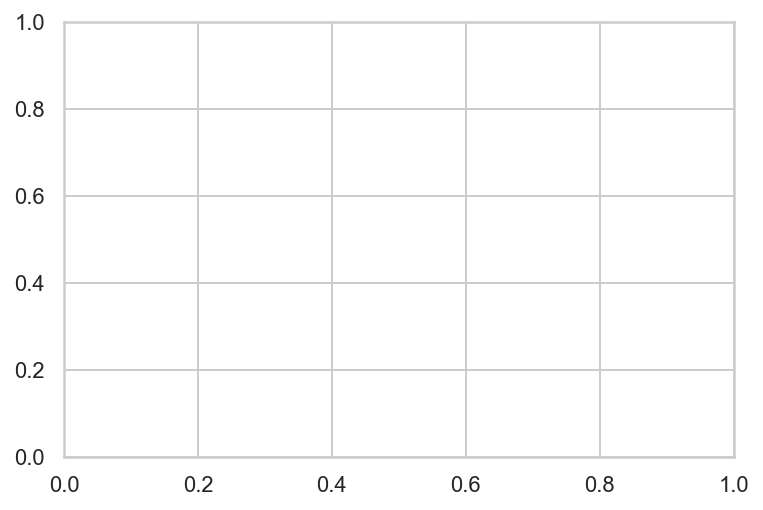

In [39]:
# Todo
# arrange by ratio
# frequency of at least 5
# CountVectorizer can do stuff like that
# Minimum document frequency in CountVectorizer
